In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_0609_fld*.pth')]
len(model_wt_fnames), model_wt_fnames[:5]

(9,
 ['haha_clas_0609_fld0_299965.pth',
  'haha_clas_0609_fld1_84154.pth',
  'haha_clas_0609_fld0_84154.pth',
  'haha_clas_0609_fld3_84154.pth',
  'haha_clas_0609_fld4_84154.pth'])

In [8]:
!grep Clas ./prod/out_fwd_tmp101.txt > ./by_seed_fwd_perf

In [9]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,acc,F1,rnd_seed,nfold
0,Clas Fold: 0 RndSeed: 84154,0.863333,0.820109,84154,0
1,Clas Fold: 1 RndSeed: 84154,0.870625,0.826782,84154,1
2,Clas Fold: 2 RndSeed: 84154,0.865833,0.826363,84154,2
3,Clas Fold: 3 RndSeed: 84154,0.861667,0.816809,84154,3
4,Clas Fold: 4 RndSeed: 84154,0.863750,0.824062,84154,4


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

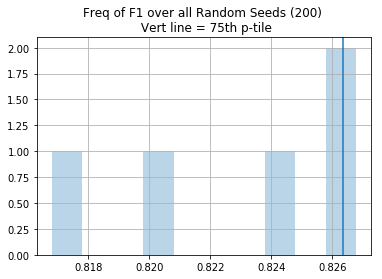

In [11]:
valid_perf.F1.hist(alpha=0.3)
#valid_perf.groupby('rnd_seed')['F1'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.F1.quantile(0.75))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

In [14]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['F1'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1>=seed_grouped_F1.quantile(0.)].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_clas_0609_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_clas_0609_fld0_84154.pth',
 'haha_clas_0609_fld1_84154.pth',
 'haha_clas_0609_fld2_84154.pth',
 'haha_clas_0609_fld3_84154.pth',
 'haha_clas_0609_fld4_84154.pth']

In [15]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [16]:
np.array(ensemble_preds).shape

(5, 6000, 2)

In [17]:
np.array(ensemble_preds)

array([[[0.295374, 0.704626],
        [0.933064, 0.066936],
        [0.03395 , 0.96605 ],
        [0.929978, 0.070022],
        ...,
        [0.856792, 0.143208],
        [0.844322, 0.155678],
        [0.343946, 0.656054],
        [0.216388, 0.783612]],

       [[0.189008, 0.810992],
        [0.952272, 0.047728],
        [0.084021, 0.915978],
        [0.929111, 0.070889],
        ...,
        [0.704143, 0.295857],
        [0.967521, 0.032479],
        [0.394713, 0.605287],
        [0.229939, 0.770061]],

       [[0.184139, 0.815861],
        [0.795188, 0.204812],
        [0.049603, 0.950397],
        [0.962914, 0.037086],
        ...,
        [0.50402 , 0.49598 ],
        [0.988681, 0.011319],
        [0.261577, 0.738423],
        [0.142204, 0.857796]],

       [[0.406496, 0.593504],
        [0.846026, 0.153974],
        [0.101522, 0.898478],
        [0.941589, 0.058411],
        ...,
        [0.693508, 0.306492],
        [0.943625, 0.056375],
        [0.425064, 0.574936],
        [0.2

In [18]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.287223, 0.712777],
       [0.890669, 0.109331],
       [0.059286, 0.940714],
       [0.951562, 0.048438],
       ...,
       [0.735775, 0.264225],
       [0.944943, 0.055057],
       [0.348418, 0.651582],
       [0.199498, 0.800502]], dtype=float32)

In [19]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [20]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [21]:
out_df.to_csv('sub0609_finetune.csv',header=True,index=False)